In [1]:
# !pip install sodapy
# !pip install feather-format
# !pip install geopandas


In [2]:
import pandas as pd
import numpy as np
from sodapy import Socrata
import collections
import re
from time import time
import math
import feather
from collections import defaultdict
import geopandas as gpd
from shapely.geometry import Point
from datetime import datetime
import itertools
from tqdm import tqdm_notebook as tqdm
from scripts.utils import exchange_coordinate, epsg_converter, df_2_geodf

# SF police data

In [3]:
# Load SF Police Data
df = feather.read_dataframe('data/sf_incidents.feather')
print(df.shape)
df.head()

(695366, 7)


,incident_date,incident_dow,incident_number,incident_time,latitude,longitude,incident_type
0,2018-12-02,Sunday,180908554,00:45,37.784908299430455,-122.40479506275997,b'other'
1,2018-12-01,Saturday,180908112,20:30,37.78640961281089,-122.40803623744476,b'other'
2,2019-03-18,Monday,190194129,14:01,37.75683373380551,-122.40669900268833,b'violent'
3,2019-03-20,Wednesday,190199583,08:00,37.784006612420036,-122.40486479517743,b'property'
4,2019-02-17,Sunday,196036034,22:45,37.80019018537176,-122.44117737724194,b'other'


In [4]:
df.dtypes

incident_date      datetime64[ns]
incident_dow               object
incident_number            object
incident_time              object
latitude                   object
longitude                  object
incident_type              object
dtype: object

In [5]:
# dtype convert
# int
int_cols = ["incident_number"]
for i_col in int_cols:
    df[i_col] = df[i_col].astype(int)
    
# float
float_cols = ["latitude", "longitude"]
for f_col in float_cols:
    df[f_col] = df[f_col].astype(float)
    
# datetime
df["datetime"] = pd.to_datetime(df.incident_date.astype(str) + " " + df.incident_time)

In [6]:
# missing value
df.isnull().sum()

incident_date      0
incident_dow       0
incident_number    0
incident_time      0
latitude           0
longitude          0
incident_type      0
datetime           0
dtype: int64

In [7]:
# drop rows with missing latitude nor langitude
df.dropna(axis=0, subset=["latitude"], inplace=True)
print(df.shape)

(695366, 8)


In [8]:
df = exchange_coordinate(df, lon="longitude", lat="latitude", prefix="crime")

In [9]:
# Load SF Census Track Data
census_tracts = gpd.read_file('data/census2010_ sf_tracks.geojson')
census_tracts = census_tracts.loc[census_tracts.tractce10 != "980401",
                                  ['geometry', "name10", 'namelsad10', "geoid10"]]  # Keep only census track name / geometrydf

# Load SF Census Block Data
census_blocks = gpd.read_file('data/census2010_ sf_blocks.geojson')
census_blocks = census_blocks.loc[census_blocks.tractce10 != "980401",
                                  ['geometry', "blockce10", 'name10', "geoid10"]]   # Keep only census track name / geometrydf

In [10]:
print(df.describe())
print(df.head())

       incident_number       latitude      longitude  crime_lon_fix  \
count     6.953660e+05  695366.000000  695366.000000  695366.000000   
mean      1.683439e+08     -79.455531      -5.198967    -122.423596   
std       1.341630e+07      70.971602      70.970969       0.026187   
min       1.131000e+06    -122.513642    -122.511295    -122.513642   
25%       1.590057e+08    -122.424719    -122.393597    -122.433843   
50%       1.703190e+08    -122.409185      37.762744    -122.417105   
75%       1.802305e+08      37.725094      37.782246    -122.406742   
max       9.910090e+08      37.829991      37.819975    -122.363743   

       crime_lat_fix  
count  695366.000000  
mean       37.769097  
std         0.023841  
min        37.707879  
25%        37.756482  
50%        37.775421  
75%        37.785222  
max        37.829991  
  incident_date incident_dow  incident_number incident_time   latitude  \
0    2018-12-02       Sunday        180908554         00:45  37.784908   
1    

In [11]:
# set crs
geodfs = [census_tracts, census_blocks]

for geodf in geodfs:
    geodf = epsg_converter(geodf)
    
# add geometory
crs = {'init':'epsg:4326'}
df = df_2_geodf(df, crs, lon="crime_lon_fix", lat="crime_lat_fix")

In [12]:
census_tracts.head()

,geometry,name10,namelsad10,geoid10
0,"(POLYGON ((-122.446471 37.775802, -122.44478 3...",165,Census Tract 165,06075016500
1,"(POLYGON ((-122.44034 37.77658, -122.439844 37...",164,Census Tract 164,06075016400
2,"(POLYGON ((-122.429152 37.778007, -122.428909 ...",163,Census Tract 163,06075016300
3,"(POLYGON ((-122.428909 37.778039, -122.429152 ...",161,Census Tract 161,06075016100
4,"(POLYGON ((-122.420425 37.780583, -122.420336 ...",160,Census Tract 160,06075016000


In [13]:
census_tracts.plot()

In [14]:
census_blocks.head()

,geometry,blockce10,name10,geoid10
0,"(POLYGON ((-122.440616 37.750902, -122.440459 ...",2002,Block 2002,060750213002002
1,"(POLYGON ((-122.438397 37.750226, -122.43832 3...",2000,Block 2000,060750213002000
2,"(POLYGON ((-122.435808 37.757623, -122.435642 ...",3004,Block 3004,060750205003004
3,"(POLYGON ((-122.436527 37.75354, -122.436454 3...",1003,Block 1003,060750212001003
4,"(POLYGON ((-122.432331 37.756227, -122.432254 ...",4001,Block 4001,060750211004001


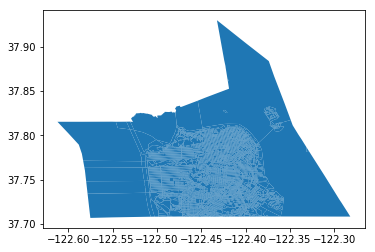

In [15]:
census_blocks.plot()

CPU times: user 767 ms, sys: 46.7 ms, total: 814 ms
Wall time: 646 ms


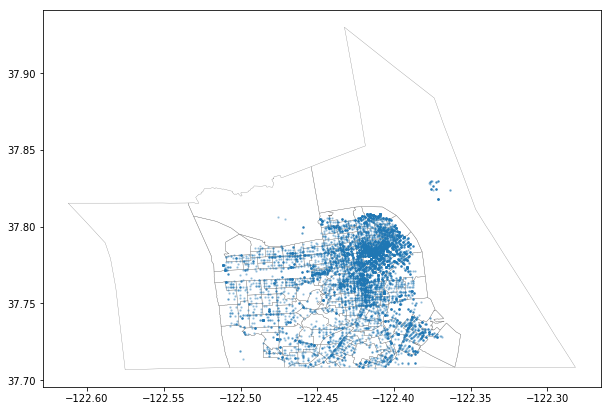

In [16]:
%%time
# ploc crime on SF map
base = census_tracts.plot(color='none', edgecolor='gray', linewidth=.3, figsize=(10,10))
df[:10000].plot(ax=base, markersize=2, alpha=0.3)

In [17]:
df.crime_lat_fix.describe()

count    695366.000000
mean         37.769097
std           0.023841
min          37.707879
25%          37.756482
50%          37.775421
75%          37.785222
max          37.829991
Name: crime_lat_fix, dtype: float64

In [18]:
%%time
# spatial join
df = gpd.sjoin(df, census_tracts, how="left", op="intersects")
df.drop("index_right", axis=1, inplace=True)
df = gpd.sjoin(df, census_blocks, how="left", op="intersects", lsuffix="tract", rsuffix="block")
df.drop("index_block", axis=1, inplace=True)

print(df.shape)
print(df.head())

(695377, 17)
  incident_date incident_dow  incident_number incident_time   latitude  \
0    2018-12-02       Sunday        180908554         00:45  37.784908   
1    2018-12-01     Saturday        180908112         20:30  37.786410   
2    2019-03-18       Monday        190194129         14:01  37.756834   
3    2019-03-20    Wednesday        190199583         08:00  37.784007   
4    2019-02-17       Sunday        196036034         22:45  37.800190   

    longitude incident_type            datetime  crime_lon_fix  crime_lat_fix  \
0 -122.404795      b'other' 2018-12-02 00:45:00    -122.404795      37.784908   
1 -122.408036      b'other' 2018-12-01 20:30:00    -122.408036      37.786410   
2 -122.406699    b'violent' 2019-03-18 14:01:00    -122.406699      37.756834   
3 -122.404865   b'property' 2019-03-20 08:00:00    -122.404865      37.784007   
4 -122.441177      b'other' 2019-02-17 22:45:00    -122.441177      37.800190   

                                       geometry name10_

# Weather data

In [19]:
# Weather Data via NOAA request
weather = pd.read_csv('data/weather.csv')
weather = weather[['NAME',  'LATITUDE',  'LONGITUDE', 'DATE', 'PRCP', 'TAVG']]
weather = exchange_coordinate(weather, lon="LONGITUDE", lat="LATITUDE", prefix="station")
weather = df_2_geodf(weather, df.crs, lon="station_lon_fix", lat="station_lat_fix")
print(weather.describe())
print(weather.head())

/usr/local/var/pyenv/versions/3.7.2/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (19,21,23,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


            LATITUDE      LONGITUDE           PRCP          TAVG  \
count  120530.000000  120530.000000  105010.000000  20127.000000   
mean       37.804167    -122.286561       0.097325     58.090277   
std         0.207808       0.221397       0.319468      9.046352   
min        37.375400    -122.702200       0.000000     33.000000   
25%        37.619700    -122.482500       0.000000     52.000000   
50%        37.869800    -122.260500       0.000000     57.000000   
75%        37.983300    -122.115000       0.000000     63.000000   
max        38.210200    -121.865500       7.570000    109.000000   

       station_lon_fix  station_lat_fix  
count    120530.000000    120530.000000  
mean       -122.286561        37.804167  
std           0.221397         0.207808  
min        -122.702200        37.375400  
25%        -122.482500        37.619700  
50%        -122.260500        37.869800  
75%        -122.115000        37.983300  
max        -121.865500        38.210200  
         

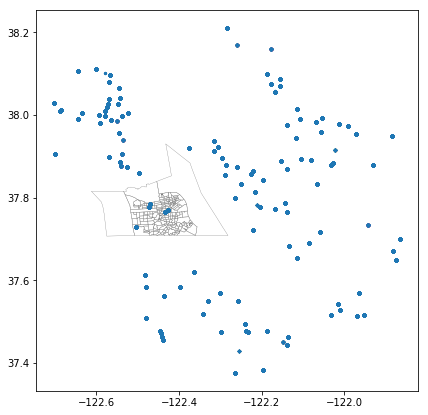

In [20]:
# plot weather station on crime map
base = census_tracts.plot(color='none', edgecolor='gray', linewidth=.3, figsize=(7,7))
weather.plot(ax=base, markersize=5)

# Merge Weather with data via Day 

In [21]:
df.head()

,incident_date,incident_dow,incident_number,incident_time,latitude,longitude,incident_type,datetime,crime_lon_fix,crime_lat_fix,geometry,name10_tract,namelsad10,geoid10_tract,blockce10,name10_block,geoid10_block
0,2018-12-02,Sunday,180908554,00:45,37.784908,-122.404795,b'other',2018-12-02 00:45:00,-122.404795,37.784908,POINT (-122.40479506276 37.78490829943046),615,Census Tract 615,06075061500,1032,Block 1032,060750615001032
1,2018-12-01,Saturday,180908112,20:30,37.786410,-122.408036,b'other',2018-12-01 20:30:00,-122.408036,37.786410,POINT (-122.4080362374448 37.78640961281089),123.01,Census Tract 123.01,06075012301,1006,Block 1006,060750123011006
2,2019-03-18,Monday,190194129,14:01,37.756834,-122.406699,b'violent',2019-03-18 14:01:00,-122.406699,37.756834,POINT (-122.4066990026883 37.75683373380551),228.02,Census Tract 228.02,06075022802,2007,Block 2007,060750228022007
3,2019-03-20,Wednesday,190199583,08:00,37.784007,-122.404865,b'property',2019-03-20 08:00:00,-122.404865,37.784007,POINT (-122.4048647951774 37.78400661242004),176.01,Census Tract 176.01,06075017601,1001,Block 1001,060750176011001
4,2019-02-17,Sunday,196036034,22:45,37.800190,-122.441177,b'other',2019-02-17 22:45:00,-122.441177,37.800190,POINT (-122.4411773772419 37.80019018537176),127,Census Tract 127,06075012700,3000,Block 3000,060750127003000


In [22]:
df = df.rename(columns={'incident_date': 'DATE'})
df.head()

,DATE,incident_dow,incident_number,incident_time,latitude,longitude,incident_type,datetime,crime_lon_fix,crime_lat_fix,geometry,name10_tract,namelsad10,geoid10_tract,blockce10,name10_block,geoid10_block
0,2018-12-02,Sunday,180908554,00:45,37.784908,-122.404795,b'other',2018-12-02 00:45:00,-122.404795,37.784908,POINT (-122.40479506276 37.78490829943046),615,Census Tract 615,06075061500,1032,Block 1032,060750615001032
1,2018-12-01,Saturday,180908112,20:30,37.786410,-122.408036,b'other',2018-12-01 20:30:00,-122.408036,37.786410,POINT (-122.4080362374448 37.78640961281089),123.01,Census Tract 123.01,06075012301,1006,Block 1006,060750123011006
2,2019-03-18,Monday,190194129,14:01,37.756834,-122.406699,b'violent',2019-03-18 14:01:00,-122.406699,37.756834,POINT (-122.4066990026883 37.75683373380551),228.02,Census Tract 228.02,06075022802,2007,Block 2007,060750228022007
3,2019-03-20,Wednesday,190199583,08:00,37.784007,-122.404865,b'property',2019-03-20 08:00:00,-122.404865,37.784007,POINT (-122.4048647951774 37.78400661242004),176.01,Census Tract 176.01,06075017601,1001,Block 1001,060750176011001
4,2019-02-17,Sunday,196036034,22:45,37.800190,-122.441177,b'other',2019-02-17 22:45:00,-122.441177,37.800190,POINT (-122.4411773772419 37.80019018537176),127,Census Tract 127,06075012700,3000,Block 3000,060750127003000


In [23]:
weather["DATE"] = pd.to_datetime(weather["DATE"])

In [24]:
weather_group = weather.groupby("DATE").mean().reset_index()

In [25]:
weather_group.dtypes

DATE               datetime64[ns]
LATITUDE                  float64
LONGITUDE                 float64
PRCP                      float64
TAVG                      float64
station_lon_fix           float64
station_lat_fix           float64
dtype: object

In [26]:
weather_group["DATE"] = pd.to_datetime(weather_group["DATE"])

In [27]:
weather_group.DATE.describe()

count                    1570
unique                   1570
top       2015-07-19 00:00:00
freq                        1
first     2015-01-01 00:00:00
last      2019-04-19 00:00:00
Name: DATE, dtype: object

In [28]:
df.DATE.describe()

count                  695377
unique                   1575
top       2015-06-28 00:00:00
freq                     1176
first     2015-01-01 00:00:00
last      2019-04-24 00:00:00
Name: DATE, dtype: object

In [29]:
df_weather = pd.merge(df, weather_group, on='DATE', how ="left")

In [30]:
print(df.shape)
print(df_weather.shape)
print(df_weather.shape)
print(df_weather.describe())
df_weather.head()

(695377, 17)
(695377, 23)
(695377, 23)
       incident_number       latitude      longitude  crime_lon_fix  \
count     6.953770e+05  695377.000000  695377.000000  695377.000000   
mean      1.683441e+08     -79.454369      -5.200131    -122.423596   
std       1.341632e+07      70.972209      70.971577       0.026186   
min       1.131000e+06    -122.513642    -122.511295    -122.513642   
25%       1.590057e+08    -122.424719    -122.393597    -122.433843   
50%       1.703191e+08    -122.409185      37.762744    -122.417105   
75%       1.802305e+08      37.725094      37.782246    -122.406742   
max       9.910090e+08      37.829991      37.819975    -122.363743   

       crime_lat_fix       LATITUDE      LONGITUDE           PRCP  \
count  695377.000000  694351.000000  694351.000000  694351.000000   
mean       37.769097      37.804223    -122.285885       0.075583   
std         0.023841       0.009863       0.014422       0.230497   
min        37.707879      37.771889    -122.3

,DATE,incident_dow,incident_number,incident_time,latitude,longitude,incident_type,datetime,crime_lon_fix,crime_lat_fix,...,geoid10_tract,blockce10,name10_block,geoid10_block,LATITUDE,LONGITUDE,PRCP,TAVG,station_lon_fix,station_lat_fix
0,2018-12-02,Sunday,180908554,00:45,37.784908,-122.404795,b'other',2018-12-02 00:45:00,-122.404795,37.784908,...,06075061500,1032,Block 1032,060750615001032,37.806897,-122.287810,0.078333,46.230769,-122.287810,37.806897
1,2018-12-01,Saturday,180908112,20:30,37.786410,-122.408036,b'other',2018-12-01 20:30:00,-122.408036,37.786410,...,06075012301,1006,Block 1006,060750123011006,37.820399,-122.301877,0.237073,49.076923,-122.301877,37.820399
2,2019-03-18,Monday,190194129,14:01,37.756834,-122.406699,b'violent',2019-03-18 14:01:00,-122.406699,37.756834,...,06075022802,2007,Block 2007,060750228022007,37.794963,-122.271899,0.000000,60.461538,-122.271899,37.794963
3,2019-03-20,Wednesday,190199583,08:00,37.784007,-122.404865,b'property',2019-03-20 08:00:00,-122.404865,37.784007,...,06075017601,1001,Block 1001,060750176011001,37.814725,-122.293813,0.461014,51.384615,-122.293813,37.814725
4,2019-02-17,Sunday,196036034,22:45,37.800190,-122.441177,b'other',2019-02-17 22:45:00,-122.441177,37.800190,...,06075012700,3000,Block 3000,060750127003000,37.811260,-122.287115,0.169726,43.153846,-122.287115,37.811260


# Collapse BY Time Period

In [31]:
# I am not sure this code is correct in order to extract hour values from the columns "incident_time"
df_weather['hour'] = pd.to_datetime(df_weather['incident_time'], format='%H:%M').dt.hour

In [32]:
print(df_weather.shape)
df_weather.isnull().sum()

(695377, 24)


DATE                  0
incident_dow          0
incident_number       0
incident_time         0
latitude              0
longitude             0
incident_type         0
datetime              0
crime_lon_fix         0
crime_lat_fix         0
geometry              0
name10_tract        128
namelsad10          128
geoid10_tract       128
blockce10           128
name10_block        128
geoid10_block       128
LATITUDE           1026
LONGITUDE          1026
PRCP               1026
TAVG               1026
station_lon_fix    1026
station_lat_fix    1026
hour                  0
dtype: int64

In [33]:
#For now, I dropped Nan values.
df_weather = df_weather.dropna()
print(df_weather.shape)

(694223, 24)


In [34]:
df_weather.head()

,DATE,incident_dow,incident_number,incident_time,latitude,longitude,incident_type,datetime,crime_lon_fix,crime_lat_fix,...,blockce10,name10_block,geoid10_block,LATITUDE,LONGITUDE,PRCP,TAVG,station_lon_fix,station_lat_fix,hour
0,2018-12-02,Sunday,180908554,00:45,37.784908,-122.404795,b'other',2018-12-02 00:45:00,-122.404795,37.784908,...,1032,Block 1032,060750615001032,37.806897,-122.287810,0.078333,46.230769,-122.287810,37.806897,0
1,2018-12-01,Saturday,180908112,20:30,37.786410,-122.408036,b'other',2018-12-01 20:30:00,-122.408036,37.786410,...,1006,Block 1006,060750123011006,37.820399,-122.301877,0.237073,49.076923,-122.301877,37.820399,20
2,2019-03-18,Monday,190194129,14:01,37.756834,-122.406699,b'violent',2019-03-18 14:01:00,-122.406699,37.756834,...,2007,Block 2007,060750228022007,37.794963,-122.271899,0.000000,60.461538,-122.271899,37.794963,14
3,2019-03-20,Wednesday,190199583,08:00,37.784007,-122.404865,b'property',2019-03-20 08:00:00,-122.404865,37.784007,...,1001,Block 1001,060750176011001,37.814725,-122.293813,0.461014,51.384615,-122.293813,37.814725,8
4,2019-02-17,Sunday,196036034,22:45,37.800190,-122.441177,b'other',2019-02-17 22:45:00,-122.441177,37.800190,...,3000,Block 3000,060750127003000,37.811260,-122.287115,0.169726,43.153846,-122.287115,37.811260,22


In [35]:
df_weather.dtypes

DATE               datetime64[ns]
incident_dow               object
incident_number             int64
incident_time              object
latitude                  float64
longitude                 float64
incident_type              object
datetime           datetime64[ns]
crime_lon_fix             float64
crime_lat_fix             float64
geometry                   object
name10_tract               object
namelsad10                 object
geoid10_tract              object
blockce10                  object
name10_block               object
geoid10_block              object
LATITUDE                  float64
LONGITUDE                 float64
PRCP                      float64
TAVG                      float64
station_lon_fix           float64
station_lat_fix           float64
hour                        int64
dtype: object

In [36]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

In [37]:
incident_type = df['incident_type'].value_counts()
print(incident_type)

b'other'       380980
b'property'    258232
b'violent'      56165
Name: incident_type, dtype: int64


In [38]:
# numeric converter
df_weather['incident_number'] = df_weather['incident_number'].astype(int)
df_weather["incident_type"] = df_weather["incident_type"].map(
    {b"violent":0,
     b"property":1,
     b"other":2}).astype(int)
df_weather["incident_dow"] = df_weather["incident_dow"].map({"Monday": 0, "Tuesday": 1,
  "Wednesday":2,"Thursday":3,"Friday":4, "Saturday":5,"Sunday":6}).astype(int)

In [39]:
df_weather.head()

,DATE,incident_dow,incident_number,incident_time,latitude,longitude,incident_type,datetime,crime_lon_fix,crime_lat_fix,geometry,name10_tract,namelsad10,geoid10_tract,blockce10,name10_block,geoid10_block,LATITUDE,LONGITUDE,PRCP,TAVG,station_lon_fix,station_lat_fix,hour
0,2018-12-02,6,180908554,00:45,37.784908,-122.404795,2,2018-12-02 00:45:00,-122.404795,37.784908,POINT (-122.40479506276 37.78490829943046),615,Census Tract 615,06075061500,1032,Block 1032,060750615001032,37.806897,-122.287810,0.078333,46.230769,-122.287810,37.806897,0
1,2018-12-01,5,180908112,20:30,37.786410,-122.408036,2,2018-12-01 20:30:00,-122.408036,37.786410,POINT (-122.4080362374448 37.78640961281089),123.01,Census Tract 123.01,06075012301,1006,Block 1006,060750123011006,37.820399,-122.301877,0.237073,49.076923,-122.301877,37.820399,20
2,2019-03-18,0,190194129,14:01,37.756834,-122.406699,0,2019-03-18 14:01:00,-122.406699,37.756834,POINT (-122.4066990026883 37.75683373380551),228.02,Census Tract 228.02,06075022802,2007,Block 2007,060750228022007,37.794963,-122.271899,0.000000,60.461538,-122.271899,37.794963,14
3,2019-03-20,2,190199583,08:00,37.784007,-122.404865,1,2019-03-20 08:00:00,-122.404865,37.784007,POINT (-122.4048647951774 37.78400661242004),176.01,Census Tract 176.01,06075017601,1001,Block 1001,060750176011001,37.814725,-122.293813,0.461014,51.384615,-122.293813,37.814725,8
4,2019-02-17,6,196036034,22:45,37.800190,-122.441177,2,2019-02-17 22:45:00,-122.441177,37.800190,POINT (-122.4411773772419 37.80019018537176),127,Census Tract 127,06075012700,3000,Block 3000,060750127003000,37.811260,-122.287115,0.169726,43.153846,-122.287115,37.811260,22


In [40]:
df_weather.isnull().sum()

DATE               0
incident_dow       0
incident_number    0
incident_time      0
latitude           0
longitude          0
incident_type      0
datetime           0
crime_lon_fix      0
crime_lat_fix      0
geometry           0
name10_tract       0
namelsad10         0
geoid10_tract      0
blockce10          0
name10_block       0
geoid10_block      0
LATITUDE           0
LONGITUDE          0
PRCP               0
TAVG               0
station_lon_fix    0
station_lat_fix    0
hour               0
dtype: int64

In [41]:
old_cols = list(df_weather.columns)

df_dummies = pd.get_dummies(df_weather, columns=['incident_type'])
dummy_cols = [col for col in df_dummies.columns if col not in old_cols]

df_dummies = pd.get_dummies(df_dummies, columns=['incident_dow'])

print(df_dummies.shape)
df_dummies.head()

(694223, 32)


,DATE,incident_number,incident_time,latitude,longitude,datetime,crime_lon_fix,crime_lat_fix,geometry,name10_tract,namelsad10,geoid10_tract,blockce10,name10_block,geoid10_block,LATITUDE,LONGITUDE,PRCP,TAVG,station_lon_fix,station_lat_fix,hour,incident_type_0,incident_type_1,incident_type_2,incident_dow_0,incident_dow_1,incident_dow_2,incident_dow_3,incident_dow_4,incident_dow_5,incident_dow_6
0,2018-12-02,180908554,00:45,37.784908,-122.404795,2018-12-02 00:45:00,-122.404795,37.784908,POINT (-122.40479506276 37.78490829943046),615,Census Tract 615,06075061500,1032,Block 1032,060750615001032,37.806897,-122.287810,0.078333,46.230769,-122.287810,37.806897,0,0,0,1,0,0,0,0,0,0,1
1,2018-12-01,180908112,20:30,37.786410,-122.408036,2018-12-01 20:30:00,-122.408036,37.786410,POINT (-122.4080362374448 37.78640961281089),123.01,Census Tract 123.01,06075012301,1006,Block 1006,060750123011006,37.820399,-122.301877,0.237073,49.076923,-122.301877,37.820399,20,0,0,1,0,0,0,0,0,1,0
2,2019-03-18,190194129,14:01,37.756834,-122.406699,2019-03-18 14:01:00,-122.406699,37.756834,POINT (-122.4066990026883 37.75683373380551),228.02,Census Tract 228.02,06075022802,2007,Block 2007,060750228022007,37.794963,-122.271899,0.000000,60.461538,-122.271899,37.794963,14,1,0,0,1,0,0,0,0,0,0
3,2019-03-20,190199583,08:00,37.784007,-122.404865,2019-03-20 08:00:00,-122.404865,37.784007,POINT (-122.4048647951774 37.78400661242004),176.01,Census Tract 176.01,06075017601,1001,Block 1001,060750176011001,37.814725,-122.293813,0.461014,51.384615,-122.293813,37.814725,8,0,1,0,0,0,1,0,0,0,0
4,2019-02-17,196036034,22:45,37.800190,-122.441177,2019-02-17 22:45:00,-122.441177,37.800190,POINT (-122.4411773772419 37.80019018537176),127,Census Tract 127,06075012700,3000,Block 3000,060750127003000,37.811260,-122.287115,0.169726,43.153846,-122.287115,37.811260,22,0,0,1,0,0,0,0,0,0,1


In [42]:
df_dummies = df_dummies.drop(columns = ['incident_time','LATITUDE','LONGITUDE'])

In [43]:
df_dummies.head()

,DATE,incident_number,latitude,longitude,datetime,crime_lon_fix,crime_lat_fix,geometry,name10_tract,namelsad10,geoid10_tract,blockce10,name10_block,geoid10_block,PRCP,TAVG,station_lon_fix,station_lat_fix,hour,incident_type_0,incident_type_1,incident_type_2,incident_dow_0,incident_dow_1,incident_dow_2,incident_dow_3,incident_dow_4,incident_dow_5,incident_dow_6
0,2018-12-02,180908554,37.784908,-122.404795,2018-12-02 00:45:00,-122.404795,37.784908,POINT (-122.40479506276 37.78490829943046),615,Census Tract 615,06075061500,1032,Block 1032,060750615001032,0.078333,46.230769,-122.287810,37.806897,0,0,0,1,0,0,0,0,0,0,1
1,2018-12-01,180908112,37.786410,-122.408036,2018-12-01 20:30:00,-122.408036,37.786410,POINT (-122.4080362374448 37.78640961281089),123.01,Census Tract 123.01,06075012301,1006,Block 1006,060750123011006,0.237073,49.076923,-122.301877,37.820399,20,0,0,1,0,0,0,0,0,1,0
2,2019-03-18,190194129,37.756834,-122.406699,2019-03-18 14:01:00,-122.406699,37.756834,POINT (-122.4066990026883 37.75683373380551),228.02,Census Tract 228.02,06075022802,2007,Block 2007,060750228022007,0.000000,60.461538,-122.271899,37.794963,14,1,0,0,1,0,0,0,0,0,0
3,2019-03-20,190199583,37.784007,-122.404865,2019-03-20 08:00:00,-122.404865,37.784007,POINT (-122.4048647951774 37.78400661242004),176.01,Census Tract 176.01,06075017601,1001,Block 1001,060750176011001,0.461014,51.384615,-122.293813,37.814725,8,0,1,0,0,0,1,0,0,0,0
4,2019-02-17,196036034,37.800190,-122.441177,2019-02-17 22:45:00,-122.441177,37.800190,POINT (-122.4411773772419 37.80019018537176),127,Census Tract 127,06075012700,3000,Block 3000,060750127003000,0.169726,43.153846,-122.287115,37.811260,22,0,0,1,0,0,0,0,0,0,1


In [44]:
# df_new = pd.DataFrame()
# df_group = df_dummies.groupby(["DATE", "hour"])
# df_new = df_group.agg({ 'incident_number': 'nunique',
#     'incident_type_0': lambda x: x.sum() / x.count(),
#     'incident_type_1': lambda x: x.sum() / x.count(),
#     'incident_type_1': lambda x: x.sum() / x.count(),
#     'incident_dow_0': lambda x: x.sum() / x.count(),
#     'incident_dow_1': lambda x: x.sum() / x.count(),
#     'incident_dow_2': lambda x: x.sum() / x.count(),                       
#     'incident_dow_3': lambda x: x.sum() / x.count(),
#     'incident_dow_4': lambda x: x.sum() / x.count(),
#     'incident_dow_5': lambda x: x.sum() / x.count(),
#     'incident_dow_6': lambda x: x.sum() / x.count(),
#     'PRCP': lambda x: x.mean(),
#     'TAVG': lambda x: x.mean()}).reset_index()
# df_new.describe()

In [45]:
# df_new.head()

# time-series and geospatial aggregation

In [64]:
def aggregate_by_time_geo(df, agg, interval, geo_unit, multi=True):
    """
    return aggregated dataframe by interval and geo_unit
    """
    if "datetime" in list(df.columns):
        df.set_index("datetime", inplace=True)
    
    # aggregate
    df = df.groupby(geo_unit).resample(interval).agg(agg)

    # clean
    n_levels = df.columns.nlevels
    if n_levels == 2:
        df.columns = df.columns.droplevel(-1)
    
    # fill out empty time (align all geoid's length of timesteps)
    if "incident_type_0" in df.columns:
        values = ["incident_type_0", "incident_type_1", "incident_type_2"]
    elif "DATE" in df.columns:
        values = ["DATE"]
    
    df = pd.pivot_table(data=df, index="datetime", columns="geoid10_tract",
                        values=values)
    df = df.fillna(0).stack().reset_index()
    
    return df

In [65]:
# all combinations of inverval, geographical unit, number of category
# time interval
intervals = [
    "1H",
    "2H",
]

# geographical unit
geo_units = [
    "geoid10_tract",
#     "geoid10_block",
]

# for multi-category counter
multi_agg = {}
for d_col in dummy_cols:
    multi_agg[d_col] = ["sum"]

# for binary counter
binary_agg = {
    "DATE": ["count"],
}

# classification category
categories = {
    "multi-class": multi_agg,
    "binary": binary_agg,
}

In [66]:
for c, g, i in itertools.product(list(categories.keys()), geo_units, intervals):
    
    print("[{0:%H:%M:%S}] converting... c:{1} g:{2} i:{3} ".format(datetime.now(),c,g,i))
    
    # counts crime with given category, geo_unit, interval
    agg = categories[c] 
    df_counts = aggregate_by_time_geo(df_dummies, agg, interval=i, geo_unit=g)
    
    if c == "binary":
        df_counts["crime"] = (df_counts["DATE"] >= 1).astype(int)
        df_counts.drop("DATE", axis=1, inplace=True)
    
    df_counts.sort_values(by=["datetime", g], inplace=True)
    df_counts.reset_index(inplace=True, drop=True)
    
    # save
    path = "data/crime_counts/counts_{0}_{1}_{2}.feather".format(c, g.split("_")[1], i)
    df_counts.to_feather(path)
    print("[{0:%H:%M:%S}] saved as {1}".format(datetime.now(), path))
    print("[{0:%H:%M:%S}] shape: {1}\n".format(datetime.now(), df_counts.shape))

[22:55:57] converting... c:multi-class g:geoid10_tract i:1H 
[22:56:25] saved as data/crime_counts/counts_multi-class_tract_1H.feather
[22:56:25] shape: (7347600, 5)

[22:56:25] converting... c:multi-class g:geoid10_tract i:2H 
[22:56:40] saved as data/crime_counts/counts_multi-class_tract_2H.feather
[22:56:40] shape: (3673800, 5)

[22:56:40] converting... c:binary g:geoid10_tract i:1H 
[22:56:57] saved as data/crime_counts/counts_binary_tract_1H.feather
[22:56:57] shape: (7347600, 3)

[22:56:57] converting... c:binary g:geoid10_tract i:2H 
[22:57:07] saved as data/crime_counts/counts_binary_tract_2H.feather
[22:57:07] shape: (3673800, 3)

